In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets,models,transforms
from torch.utils.data import DataLoader

In [30]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [33]:
train_dataset = datasets.ImageFolder("./drive/MyDrive/flower_data/train",transform=transform)
test_dataset = datasets.ImageFolder("./drive/MyDrive/flower_data/val",transform=transform)
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)

In [34]:
model = models.resnet18(pretrained=True)

In [35]:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512,5)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)
num_epochs = 15
losses = []
accs = []
for epochs in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs,labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output,labels)
        running_loss += loss.item()
        pred = torch.argmax(output,dim=1)
        running_acc  += torch.mean(pred.eq(labels).float())
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader)
    running_acc /= len(train_loader)
    losses.append(running_loss)
    accs.append(running_acc)
    print("epoch: {}, loss: {}, acc: {}".format(epochs,running_loss,running_acc))


epoch: 0, loss: 1.4083964306375254, acc: 0.3917572796344757
epoch: 1, loss: 0.9007225477177164, acc: 0.7083333134651184
epoch: 2, loss: 0.6739763332449872, acc: 0.8224637508392334
epoch: 3, loss: 0.5682812190574148, acc: 0.8265398144721985
epoch: 4, loss: 0.5781853600688602, acc: 0.8269928097724915
epoch: 5, loss: 0.46290055306061456, acc: 0.8645833134651184
epoch: 6, loss: 0.42145073413848877, acc: 0.8899456858634949
epoch: 7, loss: 0.3925565196120221, acc: 0.8863224387168884
epoch: 8, loss: 0.3642963890148246, acc: 0.904891312122345
epoch: 9, loss: 0.3350865335568138, acc: 0.9134963750839233
epoch: 10, loss: 0.3535611972860668, acc: 0.8935688734054565
epoch: 11, loss: 0.33972007554510364, acc: 0.9012681245803833
epoch: 12, loss: 0.31981864182845404, acc: 0.9175724387168884
epoch: 13, loss: 0.30775242072084674, acc: 0.9053441882133484
epoch: 14, loss: 0.2794760640548623, acc: 0.9293478727340698


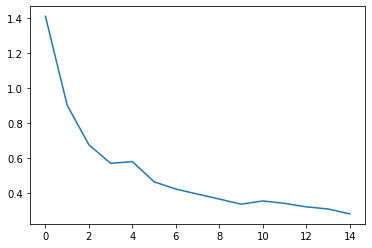

In [37]:
plt.plot(losses)

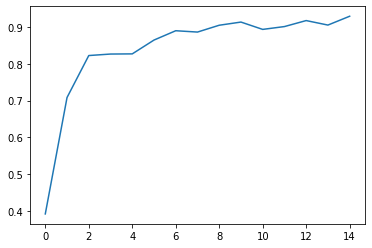

In [38]:
plt.plot(accs)

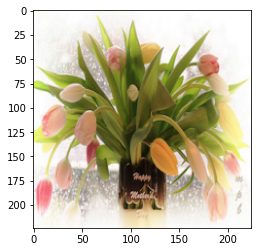

In [41]:
test_iter = iter(test_loader)
testimgs,testlabels = test_iter.next()
testimg = testimgs[0]
testimg_permute = testimg.permute(1,2,0)
testimg_permute = 0.5*testimg_permute + 0.5
testimg_permute = np.clip(testimg_permute,0,1)
plt.imshow(testimg_permute)

In [42]:
flower_name = ["daisy","dandelion","rose","sunflower","tulip"]
testimgs = testimgs.to(device)
testlabels = testlabels.to(device)
output = model(testimgs)
pred = torch.argmax(output,dim=1)
print("予測: {} >>> 正解: {}".format(flower_name[pred[0].item()],flower_name[testlabels[0].item()]))

予測: tulip >>> 正解: tulip


In [43]:
!git

usage: git [--version] [--help] [-C <path>] [-c <name>=<value>]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]

These are common Git commands used in various situations:

start a working area (see also: git help tutorial)
   clone      Clone a repository into a new directory
   init       Create an empty Git repository or reinitialize an existing one

work on the current change (see also: git help everyday)
   add        Add file contents to the index
   mv         Move or rename a file, a directory, or a symlink
   reset      Reset current HEAD to the specified state
   rm         Remove files from the working tree and from the index

examine the history and state (see also: git help revisions)
   bisect     Use binary search to find the commit that introduced a bug
   grep       Prin